 💊 Importing Libraries

In [ ]:
# Importing Libraries
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image

import pickle
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Base Path for all files
data_dir = '../input/pharmaceutical-drugs-and-vitamins-synthetic-images/Drug Vision/Data Combined'

 💊 Load Images For Training & Testing

In [ ]:
# Using ImageDataGenerator to load the Images for Training and Testing the CNN Model
datagenerator = {
    "train": ImageDataGenerator(horizontal_flip=True,
                                vertical_flip=True,
                                rescale=1. / 255,
                                validation_split=0.1,
                                shear_range=0.1,
                                zoom_range=0.1,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                rotation_range=30,
                               ).flow_from_directory(directory=data_dir,
                                                     target_size=(300, 300),
                                                     subset='training',
                                                    ),

    "valid": ImageDataGenerator(rescale=1 / 255,
                                validation_split=0.1,
                               ).flow_from_directory(directory=data_dir,
                                                     target_size=(300, 300),
                                                     subset='validation',
                                                    ),
}

Found 9000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


 💊 Initialize InceptionV3 Pretrained Model

In [ ]:
# Initializing InceptionV3 (pretrained) model with input image shape as (300, 300, 3)
base_model = InceptionV3(weights=None, include_top=False, input_shape=(300, 300, 3))

# Load Weights for the InceptionV3 Model
base_model.load_weights('../input/inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

# Setting the Training of all layers of InceptionV3 model to false
base_model.trainable = False

2022-08-27 17:59:42.779400: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-27 17:59:42.924322: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-27 17:59:42.925162: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-27 17:59:42.926342: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

 💊 Add Custom Layer

In [ ]:
# Adding some more layers at the end of the Model as per our requirement
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.15),
    Dense(1024, activation='relu'),
    Dense(10, activation='softmax') # 10 Output Neurons for 10 Classes
])

In [ ]:
# Using the Adam Optimizer to set the learning rate of our final model
opt = optimizers.Adam(learning_rate=0.0001)

# Compiling and setting the parameters we want our model to use
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

 💊 View Model Summary & Plot

In [ ]:
# Viewing the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                10250     
Total params: 23,911,210
Trainable params: 2,108,426
Non-trainable params: 21,802,784
_________________________________________________________________


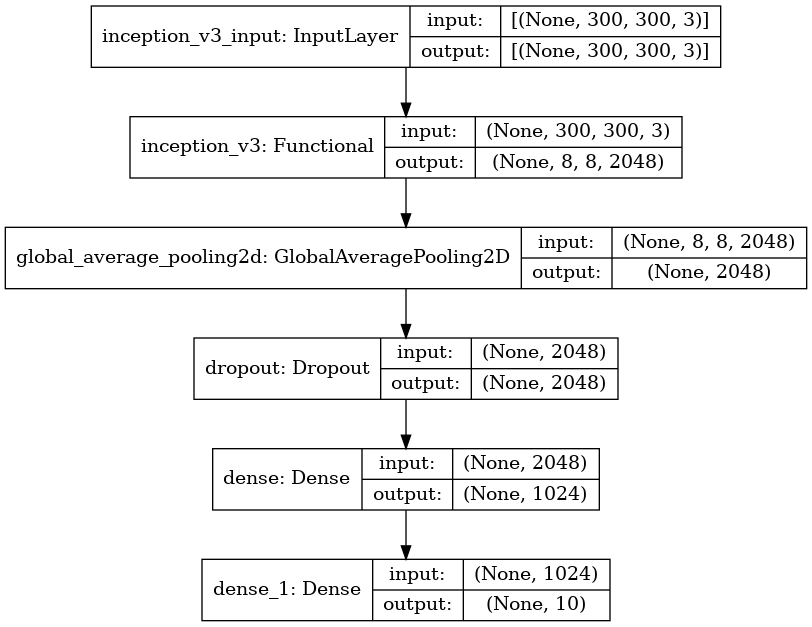

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

 💊 Model Building

In [ ]:
# Setting variables for the model
batch_size = 32
epochs = 10

# Seperating Training and Testing Data
train_generator = datagenerator["train"]
valid_generator = datagenerator["valid"]

In [ ]:
# Calculating variables for the model
steps_per_epoch = train_generator.n // batch_size
validation_steps = valid_generator.n // batch_size

print("steps_per_epoch :", steps_per_epoch)
print("validation_steps :", validation_steps)

steps_per_epoch : 281
validation_steps : 31


 💊 Model Training

In [ ]:
# File Path to store the trained models
filepath = "./model_{epoch:02d}-{val_accuracy:.2f}.h5"

# Using the ModelCheckpoint function to train and store all the best models
checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint1]
# Training the Model
history = model.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch,
                              validation_data=valid_generator, validation_steps=validation_steps,
                              callbacks=callbacks_list)

2022-08-27 18:00:01.008309: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-08-27 18:00:07.428331: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


281/281 [==============================] - 285s 974ms/step - loss: 1.3903 - accuracy: 0.5375 - val_loss: 0.9231 - val_accuracy: 0.6956

Epoch 00001: val_accuracy improved from -inf to 0.69556, saving model to ./model_01-0.70.h5
Epoch 2/10
281/281 [==============================] - 211s 751ms/step - loss: 0.9149 - accuracy: 0.6964 - val_loss: 0.7768 - val_accuracy: 0.7490

Epoch 00002: val_accuracy improved from 0.69556 to 0.74899, saving model to ./model_02-0.75.h5
Epoch 3/10
281/281 [==============================] - 206s 732ms/step - loss: 0.7906 - accuracy: 0.7303 - val_loss: 0.7429 - val_accuracy: 0.7510

Epoch 00003: val_accuracy improved from 0.74899 to 0.75101, saving model to ./model_03-0.75.h5
Epoch 4/10
281/281 [==============================] - 210s 749ms/step - loss: 0.7480 - accuracy: 0.7455 - val_loss: 0.7402 - val_accuracy: 0.7359

Epoch 00004: val_accuracy did not improve from 0.75101
Epoch 5/10
281/281 [==============================] - 212s 754ms/step - loss: 0.7047 -

 💊 Model Evaluation

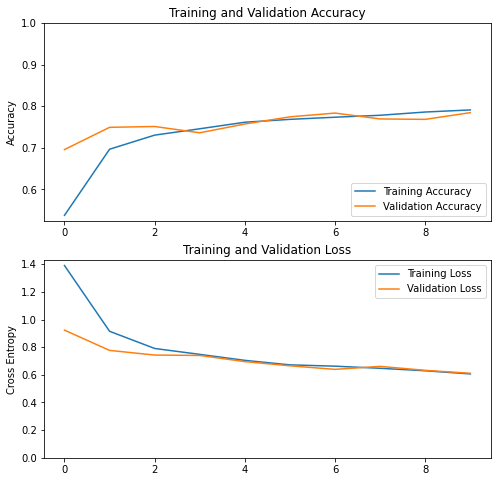

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# ________________ Graph 1 -------------------------

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# ________________ Graph 2 -------------------------

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Calculate the Loss and Accuracy on the Validation Data
test_loss, test_acc = model.evaluate(valid_generator)
print('test accuracy : ', test_acc)

32/32 [==============================] - 5s 166ms/step - loss: 0.6134 - accuracy: 0.7830
test accuracy :  0.7829999923706055


In [ ]:
# Check our folder and import the model with best validation accuracy
loaded_best_model = keras.models.load_model("./model_10-0.78.h5")

# Custom function to load and predict label for the image
def predict(img_rel_path):
    # Import Image from the path with size of (300, 300)
    img = image.load_img(img_rel_path, target_size=(300, 300))

    # Convert Image to a numpy array
    img = image.img_to_array(img, dtype=np.uint8)

    # Scaling the Image Array values between 0 and 1
    img = np.array(img)/255.0

    # Plotting the Loaded Image
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    # Get the Predicted Label for the loaded Image
    p = loaded_best_model.predict(img[np.newaxis, ...])

    # Label array
    labels = {0: 'Alaxan', 1: 'Bactidol', 2: 'Bioflu', 3: 'Biogesic', 4: 'DayZinc', 5: 'Decolgen',
              6: 'Fish Oil', 7: 'Kremil S', 8: 'Medicol', 9: 'Neozep'}

    print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = labels[np.argmax(p[0], axis=-1)]
    print("Classified:", predicted_class, "\n\n")

    classes=[]
    prob=[]
    print("\n-------------------Individual Probability--------------------------------\n")

    for i,j in enumerate (p[0],0):
        print(labels[i].upper(),':',round(j*100,2),'%')
        classes.append(labels[i])
        prob.append(round(j*100,2))
        
    def plot_bar_x():
        # this is for plotting purpose
        index = np.arange(len(classes))
        plt.bar(index, prob)
        plt.xlabel('Labels', fontsize=8)
        plt.ylabel('Probability', fontsize=8)
        plt.xticks(index, classes, fontsize=8, rotation=20)
        plt.title('Probability for loaded image')
        plt.show()
    plot_bar_x()

 💊 Model Testing With Graphs

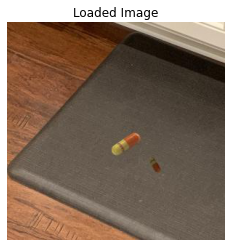



Maximum Probability:  0.9634208
Classified: Alaxan 



-------------------Individual Probability--------------------------------

ALAXAN : 96.34 %
BACTIDOL : 0.0 %
BIOFLU : 0.04 %
BIOGESIC : 3.54 %
DAYZINC : 0.0 %
DECOLGEN : 0.01 %
FISH OIL : 0.03 %
KREMIL S : 0.0 %
MEDICOL : 0.0 %
NEOZEP : 0.02 %


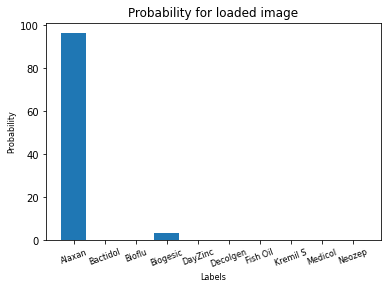

In [ ]:
predict("../input/pharmaceutical-drugs-and-vitamins-synthetic-images/Drug Vision/Data Combined/Alaxan/00000029.jpg")

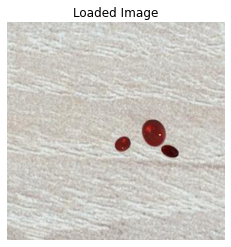



Maximum Probability:  0.9478302
Classified: Medicol 



-------------------Individual Probability--------------------------------

ALAXAN : 0.01 %
BACTIDOL : 4.49 %
BIOFLU : 0.0 %
BIOGESIC : 0.03 %
DAYZINC : 0.01 %
DECOLGEN : 0.11 %
FISH OIL : 0.17 %
KREMIL S : 0.4 %
MEDICOL : 94.78 %
NEOZEP : 0.01 %


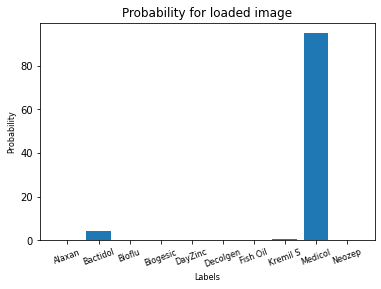

In [ ]:
predict("../input/pharmaceutical-drugs-and-vitamins-synthetic-images/Drug Vision/Data Combined/Medicol/00000029.jpg")

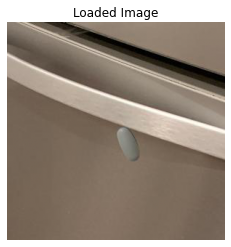



Maximum Probability:  0.55277085
Classified: Neozep 



-------------------Individual Probability--------------------------------

ALAXAN : 0.37 %
BACTIDOL : 0.51 %
BIOFLU : 8.19 %
BIOGESIC : 2.56 %
DAYZINC : 18.9 %
DECOLGEN : 1.94 %
FISH OIL : 6.86 %
KREMIL S : 5.34 %
MEDICOL : 0.04 %
NEOZEP : 55.28 %


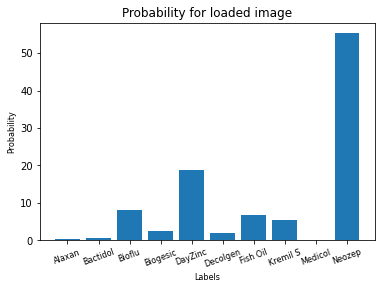

In [ ]:
predict("../input/pharmaceutical-drugs-and-vitamins-synthetic-images/Drug Vision/Data Combined/Neozep/00000029.jpg")

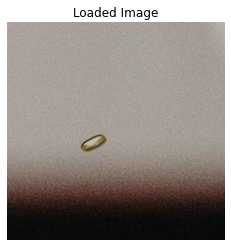



Maximum Probability:  0.86205083
Classified: Fish Oil 



-------------------Individual Probability--------------------------------

ALAXAN : 0.0 %
BACTIDOL : 0.0 %
BIOFLU : 0.14 %
BIOGESIC : 0.11 %
DAYZINC : 0.15 %
DECOLGEN : 0.0 %
FISH OIL : 86.21 %
KREMIL S : 0.02 %
MEDICOL : 0.0 %
NEOZEP : 13.37 %


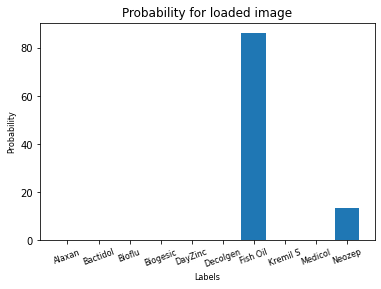

In [ ]:
predict("../input/pharmaceutical-drugs-and-vitamins-synthetic-images/Drug Vision/Data Combined/Fish Oil/00000029.jpg")